# Directory shenanigans

In [1]:
import os
import sys

# 1. repo_dir used later
repo_dir = os.path.abspath(os.path.join(os.path.abspath(""), ".."))

# 2. sys.path must be appended for importing modules
sys.path.append(repo_dir)

# 3. fix current working directory
os.chdir(os.path.abspath(os.path.join(os.path.abspath(""))))

# Import libaries + assign device (CPU/GPU)

In [2]:
from models.cm_hybrid import ContinuousMixture
from models.lo_hybrid import bins_lo, fast_bins_lo
from torch.utils.data import DataLoader
from torchvision import datasets
from utils.reproducibility import seed_everything

import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# assign device (cpu or gpu, if present)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load data

In [3]:
# choose True for MNIST and False for binary MNIST
use_mnist = False

# create data directory (if not done already)
data_dir = "../data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# download MNIST into data directory (if not done already)
mnist_test = datasets.MNIST(root="../data", train=False, download=True)
labels_mnist_test = mnist_test.targets

# convert dataset to tensor
mnist_test = mnist_test.data.view(10_000, 784).float()

# define test set and binarise if use_mnist is False
X_test = mnist_test if use_mnist else (mnist_test / 255 >= 0.5).float()
y_test = labels_mnist_test

# load val and test sets into dataloaders
batch_size = 128
test_loader = DataLoader(X_test, batch_size=batch_size)

# Load model

In [33]:
# model hyperparams
dataset = 'mnist' if use_mnist else 'bmnist'
lamda = 0.8
latent_dim = 32
num_bins_trained = 8_192
version_num = 0

# load model
model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
model.n_chunks = 32
model.missing = False # this was True before, check if difference (hope not)
model.eval(); # semi-colon to prevent printing model architecture
print(model_path)

/scratch/s3313093/cm-tpm-main/logs/bmnist/hybrid/latent_dim_32/num_bins_8192/lambda_0.80/version_0/checkpoints/best_model_valid-epoch=32.ckpt


## Evaluate mean negative log-likelihood and classification accuracies (on full and missing data) over the test data

In [5]:
# def compute_accuracies(
#     model,
#     X_test,
#     y_test,
#     lower_power_bound,
#     upper_power_bound,
#     latent_opt,
#     use_mnist,
#     missing_rate,
#     batch_size=512,
#     seed=42,
# ):
#     accuracies = []
#     n_bins_list = [2 ** k for k in range(lower_power_bound, upper_power_bound)]

#     seed_everything(seed)
#     test_lls = []
#     for n_bins in n_bins_list:
#         model.sampler.n_bins = n_bins
#         # if latent_opt:
#         #     z, log_w = bins_lo(model, n_bins, train_loader, valid_loader, max_epochs=20, lr=1e-3, patience=5, device=device)
#         # else:
#         #     z, log_w = model.sampler(seed=seed)
#         z, log_w = model.sampler(seed=seed)

#         all_ll = torch.zeros(len(X_test), 10)

#         if missing_rate == 0.0:
#             # If no missingness, we can evaluate log‐lik directly
#             test_lls.append(-model.eval_loader(test_loader, z, log_w, device=device).mean().item())

#         # ————— prepare a single mask for all digits —————
#         if missing_rate != 0.0:
#             model.missing = True
#             # draw one mask of the same shape as X_test
#             # so that the same entries are "missing" under every digit‐label hypothesis
#             mask = torch.rand_like(X_test) < missing_rate
#         else:
#             mask = None

#         for digit in range(10):
#             # start from clean copy of X_test each time
#             Xd = X_test.clone()

#             # apply the pre–computed mask (if any) so it is identical for all digit loops
#             if mask is not None:
#                 Xd[mask] = float('nan')

#             # overwrite label channels with this candidate digit
#             if use_mnist:
#                 Xd[:, -1] = digit
#             else:
#                 bitstring = [int(b) for b in bin(digit)[2:].zfill(4)]
#                 Xd[:, -4:] = torch.tensor(bitstring, dtype=torch.float)

#             loader = DataLoader(Xd, batch_size=batch_size, shuffle=False)
#             ll_chunks = []
#             with torch.no_grad():
#                 for xb in loader:
#                     xb = xb.to(device)
#                     llb = model.forward(xb, z, log_w, k=None, seed=seed)
#                     ll_chunks.append(llb.cpu())
#             all_ll[:, digit] = torch.cat(ll_chunks, dim=0)

#         # classification by maximum log‐likelihood
#         preds = all_ll.argmax(dim=1)
#         acc = (preds == y_test.squeeze()).float().mean().item()
#         accuracies.append(acc)

#     if latent_opt:
#         return n_bins_list, accuracies, z

#     return n_bins_list, accuracies, test_lls

## Plot accuracies over the test set

In [6]:
# missing_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95]
# acc_dict = {k: [] for k in missing_rates}
# test_lls = []

# for missing_rate in missing_rates:
#     n_bins_list, acc_list, test_lls_list = compute_accuracies(
#         model=model,
#         X_test=X_test,
#         y_test=y_test,
#         lower_power_bound=14,
#         upper_power_bound=15, # reduce this to 9 to speed up debugging
#         latent_opt=False,
#         use_mnist=use_mnist,
#         missing_rate=missing_rate,
#     )
#     if missing_rate == 0.0:
#         test_lls = test_lls_list
#     acc_dict[missing_rate] = acc_list

# print(f"latent_dim_{latent_dim}/n_bins_{num_bins_trained}/epoch_{int(model_path.split('epoch=')[-1].split('.', 1)[0])} - LAMBDA {lamda:.2f}")
# for i in range(len(n_bins_list)):
#     n_bins = n_bins_list[i]
#     str_to_print = f"Mean NLL and Accuracy for {n_bins:5d} components: {test_lls[i]:8.4f}"
#     for missing_rate in missing_rates:
#         str_to_print += f" : {acc_dict[missing_rate][i]:.4f}"
#     print(str_to_print)

# Monte Carlo estimator bars for classification

In [7]:
# from random import randint

# missing_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# acc_dict = {k: [] for k in missing_rates}
# num_runs = 50 # each run takes ~30s w/ N=2^9 and ~?s w/ N=2^14

# for run in range(num_runs):
#     rand_seed = randint(1, 2 ** 32 - 2)
#     for missing_rate in missing_rates:
#         n_bins_list, acc_list, test_lls_list = compute_accuracies(
#             model=model,
#             X_test=X_test,
#             y_test=y_test,
#             lower_power_bound=8,
#             upper_power_bound=9,
#             latent_opt=False,
#             use_mnist=use_mnist,
#             missing_rate=missing_rate,
#             seed=rand_seed,
#         )
#         acc_dict[missing_rate].append(acc_list[0])

In [8]:
# # missing percentages
# missing_rates = sorted(acc_dict)
# missing_pct = [m * 100 for m in missing_rates]

# # compute mean and std (%) for each missing rate
# means_pct = np.array([np.mean(acc_dict[m]) * 100 for m in missing_rates])
# stds_pct  = np.array([np.std(acc_dict[m], ddof=1) * 100 for m in missing_rates])
# print(means_pct, stds_pct)

# # upper and lower bounds
# upper = means_pct + stds_pct
# lower = means_pct - stds_pct

# # just plotting things, not too important to understand
# base_color = plt.cm.viridis(0.5)
# plt.figure(figsize=(6, 4))
# plt.fill_between(missing_pct, lower, upper, color=base_color, alpha=0.2) # shade region between the lower and upper lines
# plt.plot(missing_pct, means_pct, color=base_color, linestyle='-', marker='o', markersize=4, linewidth=2.5, label='Mean accuracy') # mean line
# plt.plot(missing_pct, upper, color=base_color, linestyle='--', linewidth=1) # upper line
# plt.plot(missing_pct, lower, color=base_color, linestyle='--', linewidth=1) # lower line
# plt.xlabel("Pixel values missing at random (%)", fontsize=10)
# plt.ylabel("Accuracy (%)", fontsize=10)
# plt.xticks(missing_pct, fontsize=9)
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# for spine in ['left', 'bottom']:
#     ax.spines[spine].set_color('#888888')
#     ax.spines[spine].set_linewidth(0.8)
# y_min = lower.min()
# y_min_tick = int(np.floor(y_min / 10) * 10)
# ax.set_yticks(np.arange(y_min_tick, 101, 10))
# ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
# ax.set_ylim(y_min, 100)
# plt.yticks(fontsize=9)
# plt.legend(loc='upper right', bbox_to_anchor=(1, 1.0085), frameon=True, edgecolor='#888888', facecolor='white', fontsize=8)
# plt.tight_layout(pad=0.5)
# plt.show()

# Display just NLLs (this is to speed up obtaining them if needed)

In [ ]:
n_bins_list = [2 ** k for k in range(8, 15)]
seed=42
seed_everything(seed=seed)

# model hyperparams
dataset = 'mnist' if use_mnist else 'bmnist'
latent_dim = 32
num_bins_trained = 8_192
version_num = 0
for lamda in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    
    # load model
    model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
    model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
    model.n_chunks = 32
    model.missing = False # this was True before, check if difference (hope not)
    model.eval(); # semi-colon to prevent printing model architecture

    out = ""
    for n_bins in n_bins_list:
        model.sampler.n_bins = n_bins
        z, log_w = model.sampler(seed=seed)
        test_ll = -model.eval_loader(test_loader, z, log_w, device=device).mean().item()
        # print(f"Mean NLL for {n_bins:5d} components: {test_ll:6.2f}")
        out += f"{test_ll:.2f} & "
    print("\hline")
    print(f"{lamda:.1f} & " + out[:-3] + 2 * "\\")

# Plot accuracies for fixed lamda and varying number of bins

In [11]:
# # Convert to percentages
# missing_rates_pct = [m * 100 for m in missing_rates]
# perf_matrix_pct = (np.array([acc_dict[m] for m in missing_rates]) * 100).T

# plt.figure(figsize=(6, 4))
# for idx, temp in enumerate(n_bins_list):
#     plt.plot(
#         missing_rates_pct,
#         perf_matrix_pct[idx],
#         linestyle='--',      # dashed lines
#         marker='o',
#         markersize=4,
#         linewidth=2.5,       # a bit thicker
#         label=str(temp),
#     )

# # Axis labels
# plt.xlabel("Pixel values missing at random (%)", fontsize=10)
# plt.ylabel("Accuracy (%)", fontsize=10)

# # X‐ticks
# plt.xticks(missing_rates_pct, fontsize=9)

# ax = plt.gca()
# # Remove top/right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # Lighten left/bottom spines
# for spine in ['left', 'bottom']:
#     ax.spines[spine].set_color('#888888')
#     ax.spines[spine].set_linewidth(0.8)

# # Dynamic y‐axis: from min accuracy up to 100%
# y_min = perf_matrix_pct.min()
# y_min_tick = int(np.floor(y_min / 10) * 10)   # round down to nearest 10
# ax.set_yticks(np.arange(y_min_tick, 101, 10))  # ticks every 10%
# # Make horizontal grid lines more prominent
# ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
# ax.set_ylim(y_min, 100)
# plt.yticks(fontsize=9)

# # Legend in top right with a box, shifted up slightly
# plt.legend(
#     loc='upper right',
#     bbox_to_anchor=(1, 1.0085),  # move legend a bit higher
#     frameon=True,
#     edgecolor='#888888',
#     facecolor='white',
#     fontsize=8
# )

# plt.tight_layout(pad=0.5)
# plt.savefig(f"../results_hybrid/figures/lam_{lamda}_acc.pdf")
# plt.savefig(f"../results_hybrid/figures/lam_{lamda}_acc.png")

# Plot accuracies for fixed number of bins and varying lambdas

In [12]:
# lamdas = [0, 0.2, 0.4, 0.6, 0.8, 1]
# missing_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# acc_dict = {k: [] for k in lamdas}
# for lamda in lamdas:
    
#     # model hyperparams
#     dataset = 'mnist' if use_mnist else 'bmnist'
#     latent_dim = 32
#     num_bins_trained = 8_192
#     version_num = 0

#     # load model
#     model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
#     model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
#     # model.sampler.n_bins = 16_384 # this is done already in the compute_acc() function, unneeded
#     model.n_chunks = 32
#     model.missing = False
#     model.eval(); # semi-colon to prevent printing model architecture

#     for missing_rate in missing_rates:
#         n_bins_list, acc_list, test_lls_list = compute_accuracies(
#             model=model,
#             X_test=X_test,
#             y_test=y_test,
#             lower_power_bound=14,
#             upper_power_bound=15,
#             latent_opt=False,
#             use_mnist=use_mnist,
#             missing_rate=missing_rate,
#         )
#         acc_dict[lamda].append(acc_list[0])

# print(f"latent_dim_{latent_dim}/n_bins_{num_bins_trained}")
# for lam in lamdas:
#     str_to_print = f"Accuracy for {lam:.1f}"
#     for i in range(len(missing_rates)):
#         str_to_print += f" : {acc_dict[lam][i]:.4f}"
#     print(str_to_print)

In [13]:
# # Convert missing rates to percentages
# missing_rates_pct = [m * 100 for m in missing_rates]

# # Convert each λ’s accuracy‐list to percentages
# lambda_dict_pct = {lam: (np.array(acc_dict[lam]) * 100) for lam in acc_dict}

# # Sort λ’s so the legend always reads in ascending order
# sorted_lambdas = sorted(lambda_dict_pct.keys())

# # Sample one color per λ from a colormap
# cmap = plt.cm.viridis
# colors = cmap(np.linspace(0, 1, len(sorted_lambdas)))

# plt.figure(figsize=(6, 4))
# for idx, lam in enumerate(sorted_lambdas):
#     acc_pct = lambda_dict_pct[lam]
#     plt.plot(
#         missing_rates_pct,
#         acc_pct,
#         # color=colors[idx],
#         linestyle='--',
#         marker='o',
#         markersize=4,
#         linewidth=2.5,
#         label=f"λ = {lam}",
#     )

# # Axis labels
# plt.xlabel("Pixel values missing at random (%)", fontsize=10)
# plt.ylabel("Accuracy (%)", fontsize=10)

# # X‐ticks
# plt.xticks(missing_rates_pct, fontsize=9)

# ax = plt.gca()
# # Remove top/right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # Lighten left/bottom spines
# for spine in ['left', 'bottom']:
#     ax.spines[spine].set_color('#888888')
#     ax.spines[spine].set_linewidth(0.8)

# # Dynamic y‐axis: from min accuracy up to 100%
# all_acc_values = np.concatenate([lambda_dict_pct[lam] for lam in sorted_lambdas])
# y_min = all_acc_values.min()
# y_min_tick = int(np.floor(y_min / 10) * 10)
# ax.set_yticks(np.arange(y_min_tick, 101, 10))
# ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
# ax.set_ylim(y_min, 100)
# plt.yticks(fontsize=9)

# # Legend in top right
# plt.legend(
#     loc='upper right',
#     bbox_to_anchor=(1, 1.0085),
#     frameon=True,
#     edgecolor='#888888',
#     facecolor='white',
#     fontsize=8
# )

# plt.tight_layout(pad=0.5)
# plt.savefig(f"../results_hybrid/figures/acc_vary_lam_ld_{latent_dim}.pdf")
# plt.show()


In [14]:
# # Convert missing rates to percentages
# missing_rates_pct = [m * 100 for m in missing_rates]

# # Convert each λ’s accuracy‐list to percentages
# lambda_dict_pct = {
#     lam: (np.array(acc_dict[lam]) * 100)
#     for lam in acc_dict
# }

# # Sort λ’s so the legend always reads in ascending order
# sorted_lambdas = sorted(lambda_dict_pct.keys())

# # Sample one color per λ from a colormap
# cmap = plt.cm.viridis
# colors = cmap(np.linspace(0, 1, len(sorted_lambdas)))

# plt.figure(figsize=(6, 4))
# for idx, lam in enumerate(sorted_lambdas):
#     acc_pct = lambda_dict_pct[lam]
#     plt.plot(
#         missing_rates_pct,
#         acc_pct,
#         # color=colors[idx],
#         linestyle='--',
#         marker='o',
#         markersize=4,
#         linewidth=1.0,
#         label=f"λ = {lam}",
#     )

# # Axis labels
# plt.xlabel("Pixel values missing at random (%)", fontsize=10)
# plt.ylabel("Accuracy (%)", fontsize=10)

# # X‐ticks
# # plt.xticks(missing_rates_pct, fontsize=9)

# x_thresh = 31
# ax = plt.gca()
# ax.set_xticks(np.arange(0, x_thresh + 1, 10))
# ax.set_xlim(0, x_thresh)
# plt.xticks(fontsize=9)

# ax = plt.gca()
# # Remove top/right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # Lighten left/bottom spines
# for spine in ['left', 'bottom']:
#     ax.spines[spine].set_color('#888888')
#     ax.spines[spine].set_linewidth(0.8)

# # Dynamic y‐axis: from min accuracy up to 100%
# all_acc_values = np.concatenate([lambda_dict_pct[lam] for lam in sorted_lambdas])
# y_min = 89
# y_min_tick = int(np.floor(y_min / 10) * 10)
# ax.set_yticks(np.arange(y_min_tick, 101, 1))
# ax.yaxis.grid(True, linestyle='--', linewidth=1.0, color='#bbbbbb')
# ax.set_ylim(89.5, 97.5)
# plt.yticks(fontsize=9)

# # Legend in top right
# plt.legend(
#     loc='upper right',
#     bbox_to_anchor=(1, 1.0085),
#     frameon=True,
#     edgecolor='#888888',
#     facecolor='white',
#     fontsize=8
# )

# plt.tight_layout(pad=0.5)
# plt.savefig(f"../results_hybrid/figures/acc_vary_lam_ld_{latent_dim}_zoomed.pdf")
# plt.show()


## Evaluate sample quality

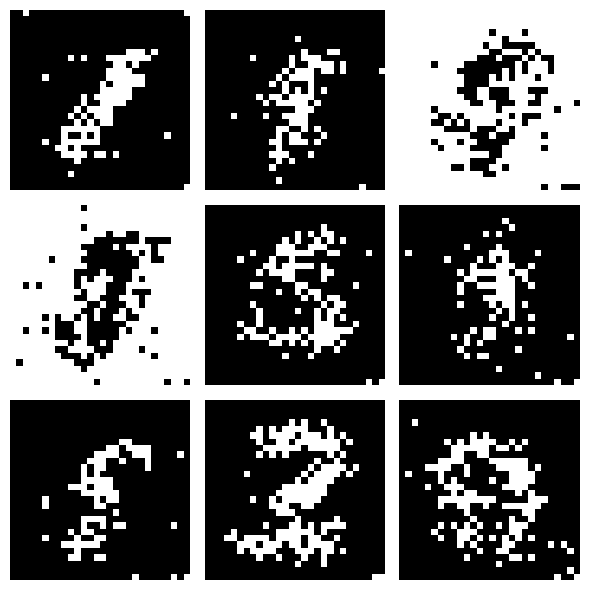

In [34]:
from random import sample

decoder_arch = 'MLP'
n_bins = 32
model.sampler.n_bins = n_bins
z, log_w = model.sampler(seed=42)
logits_tensor = model.decoder.net(z.to(device))
chosen_idxs = sample(range(n_bins), 9)

# 3 by 3 figure of samples
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
axes = axes.flatten()
for ax, idx in zip(axes, chosen_idxs):
    logits_sample = logits_tensor[idx]
    if decoder_arch == 'tConv':
        logits_permute = logits_sample.permute(1, 2, 0)
        logits_flat = logits_permute.reshape(-1, logits_permute.shape[-1])
        sampled_pixel_vals = torch.distributions.Categorical(logits=logits_flat).sample()
        img = sampled_pixel_vals.view(28, 28).detach().cpu().numpy()
    else:
        probs = torch.sigmoid(logits_sample)
        sample_flat = torch.bernoulli(probs)
        img = sample_flat.view(28, 28).detach().cpu().numpy()

    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.savefig(f"../results_hybrid/figures/samples/ld_{latent_dim}/lam_{lamda:.2f}_ld_{latent_dim}_9_samples.pdf")

# Load training and validation (for latent opt.)

In [16]:
# # download MNIST into data directory (if needed)
# mnist_train_and_val = datasets.MNIST(root="../data", train=True, download=True)

# # assign labels
# labels_mnist_train_and_val = mnist_train_and_val.targets

# # convert datasets to tensors
# mnist_train_and_val = mnist_train_and_val.data.view(60_000, 784).float()

# # embed class label in final pixel(s) of training samples
# for idx in range(mnist_train_and_val.shape[0]):
#     label = labels_mnist_train_and_val[idx]
#     if use_mnist:
#         mnist_train_and_val[idx][-1] = label
#         # bin_label = torch.tensor([int(d) for d in bin(label)[2:].zfill(4)]).float()
#         # mnist_train_and_val[idx][-4:] = bin_label
#     else:
#         binary_label = 255 * torch.tensor([int(d) for d in bin(label)[2:].zfill(4)]).float()
#         mnist_train_and_val[idx][-4:] = binary_label

# # define train and validation
# if use_mnist:
#     X_train = mnist_train_and_val[0:50_000]
#     X_val   = mnist_train_and_val[50_000::]
# else: # if use_mnist is False then binarise
#     X_train = (mnist_train_and_val[0:50_000] / 255 >= 0.5).float()
#     X_val   = (mnist_train_and_val[50_000::] / 255 >= 0.5).float()

# y_train = labels_mnist_train_and_val[0:50_000]
# y_val   = labels_mnist_train_and_val[50_000::]

# # load data into data loaders
# batch_size = 128
# train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True, drop_last=True)
# valid_loader = DataLoader(X_val  , batch_size=batch_size)

# Latent optimisation: test on full data

In [17]:
# print(model_path)
# # latent optimisation should really be done here to avoid doing it again for missing
# bins_full, acc_full, z_opt = compute_accuracies(
#     model=model,
#     X_test=X_test,
#     y_test=y_test,
#     lower_power_bound=8,
#     upper_power_bound=9,
#     latent_opt=True,
#     use_mnist=use_mnist,
#     missing=False
# )

## Evaluate sample quality

In [18]:
# def reconstruct_image(grayscale_vector):
#     image_data = grayscale_vector.reshape((28, 28))
#     plt.imshow(image_data, cmap='gray')
#     plt.axis('off')
#     plt.show()

# from random import randint

# decoder_arch = 'MLP'
# n_bins = 32
# model.sampler.n_bins = n_bins
# z, log_w = model.sampler(seed=42)
# logits_tensor = model.decoder.net(z.to(device))
# logits_sample = logits_tensor[randint(0, n_bins - 1)]

# if decoder_arch == 'tConv':
#     logits_permute = logits_sample.permute(1, 2, 0)
#     logits_flat = logits_permute.reshape(-1, logits_permute.shape[-1])
#     sampled_pixel_vals = torch.distributions.Categorical(logits=logits_flat).sample()
#     reconstruct_image(sampled_pixel_vals.view(28, 28).detach().cpu())
# else:
#     probs = torch.sigmoid(logits_sample)
#     sample = torch.bernoulli(probs)
#     reconstruct_image(sample.detach().cpu())